In [1]:
# Imports
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

import matplotlib.pyplot as plt
import pylab as pl
from IPython import display

%matplotlib inline

import time

import numpy as np

import autoencoders

In [2]:
# Set seed for reproduciblity
torch.manual_seed(7212)
np.random.seed(2980)

In [3]:
# Mnist digits dataset (download if necessary)
train_data = torchvision.datasets.FashionMNIST(
    root='./Datasets/fashion-mnist/',
    train=True,
    transform=torchvision.transforms.ToTensor(),                        
    download=False,
)

In [4]:
# Select which device to use, use the gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Currently running on:", device)

Currently running on: cuda


In [5]:
def train_model(model_name, train_data, batch_size=64, epochs=10, save_as=None, run_on="cpu", show_loss=False,
                n_test_img=0, learn_rate=0.0005):
    
    # Start timing of the training of the autoencoder
    start = time.time()
    
    # Set the save name to the model name if no name was specified
    if not save_as:
        save_as=model_name
    
    # Calculate the number of loss measurements per epoch
    n_loss_per_step = np.ceil(len(train_data)/batch_size)-1
    
    # Load the data into a dataloader so that batches can be used
    train_loader = Data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    
    # Select what type of autoencoder to use and set the training flag to True
    used_autoencoder = getattr(autoencoders, model_name)
    autoencoder = used_autoencoder().to(device)
    autoencoder.train()

    # Select what optimizer and loss function will be used for training the model
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learn_rate)
    loss_func = nn.MSELoss().to(device)
    
    print("Training:", model_name, "| In Cuda:", next(autoencoder.parameters()).is_cuda)
    
    # List where the loss values will be saved
    loss_list = []

    # Create a blank canvas with for plotting loss against the number of epochs
    if show_loss:
        pl.plot([],[])
        pl.xlim(0, epochs)
        pl.title(save_as)
        pl.xlabel("Epoch")
        pl.ylabel("Loss")
    
    # Load the number of test images 
    if n_test_img>0:
        view_data = train_data.data[:n_test_img].view(-1, 28*28).type(torch.FloatTensor).to(device)/255

    for epoch in range(epochs):
        loss_list = []
        for step, (x, _) in enumerate(train_loader):
            batch = x.view(-1, 28*28).to(device)

            encoded, decoded = autoencoder(batch)
            
            loss = loss_func(decoded, batch)    # mean square error
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients

            loss_list.append(loss.item())

            if n_test_img>0 and step % 500 == 0 and (epoch % 5 == 0 or epoch == epochs-1):        
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())

                # plotting decoded image (second row)
                _, decoded_data = autoencoder(view_data)

                # initialize figure
                f, a = plt.subplots(2, n_test_img, figsize=(n_test_img, 2))

                for i in range(n_test_img):
                    a[0][i].imshow(np.reshape(view_data.data.cpu().numpy()[i], (28, 28)), cmap='gray')
                    a[0][i].set_xticks(())
                    a[0][i].set_yticks(())

                for i in range(n_test_img):
                    a[1][i].clear()
                    a[1][i].imshow(np.reshape(decoded_data.data.cpu().numpy()[i], (28, 28)), cmap='gray')
                    a[1][i].set_xticks(())
                    a[1][i].set_yticks(())
                plt.show(); plt.pause(0.05)

        # Plot loss against epoch
        if show_loss:
            position_list = []
            for i in range(len(loss_list)):
                position_list.append(i/n_loss_per_step + epoch) 
            pl.plot(position_list, loss_list)
            display.clear_output(wait=True) # Clear display 
            print('Epoch: ', epoch, '| Average train loss: %.4f' % np.mean(loss_list))
            display.display(pl.gcf())
            time.sleep(1.0)

    # Save the weights of the trained autoencoder to a file to be used later
    torch.save(autoencoder.state_dict(), "./Trained Models/" + save_as + ".pt")
    torch.cuda.empty_cache()
    
    # End timing of the training of the autoencoder
    end = time.time()
    time_elapsed = end - start

    print("Done training in:", time.strftime('%H:%M:%S', time.gmtime(time_elapsed)),
          "| Model saved as:", save_as + ".pt")

Training: AutoEncoder | In Cuda: True
Epoch:  0 | train loss: 0.1724


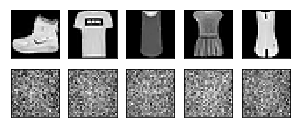

Epoch:  0 | train loss: 0.0363


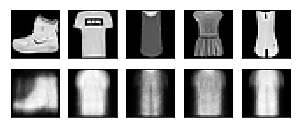

Epoch:  5 | train loss: 0.0180


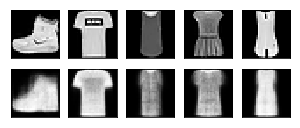

Epoch:  5 | train loss: 0.0179


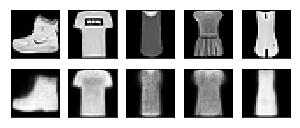

Epoch:  9 | train loss: 0.0157


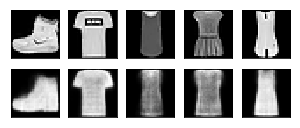

Epoch:  9 | train loss: 0.0141


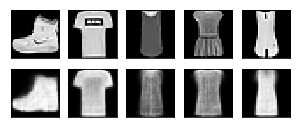

Done training in: 00:01:17 | Model saved as: AutoEncoder.pt


In [7]:
# Train regular Autoencoder
train_model("AutoEncoder", train_data, run_on=device, n_test_img=5)

Training: RandomAutoEncoder | In Cuda: True
Epoch:  0 | train loss: 0.1725


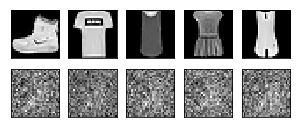

Epoch:  0 | train loss: 0.0590


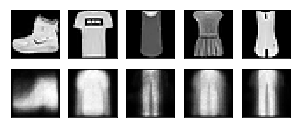

Epoch:  5 | train loss: 0.0363


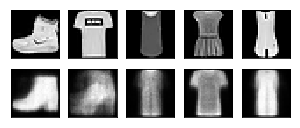

Epoch:  5 | train loss: 0.0436


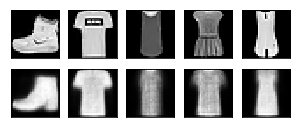

Epoch:  9 | train loss: 0.0319


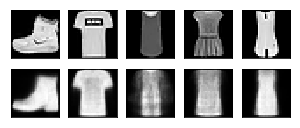

Epoch:  9 | train loss: 0.0368


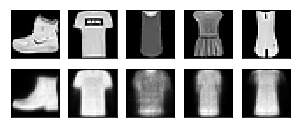

Done training in: 00:02:07 | Model saved as: RandomAutoEncoder.pt


In [8]:
# Train Random Autoencoder
train_model("RandomAutoEncoder", train_data, run_on=device, n_test_img=5)

Training: IncrementalAutoEncoder | In Cuda: True
Epoch:  0 | train loss: 0.1699


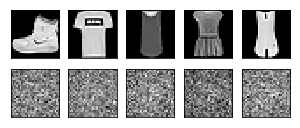

Epoch:  0 | train loss: 0.0419


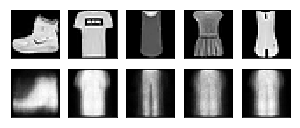

Epoch:  5 | train loss: 0.0253


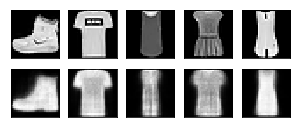

Epoch:  5 | train loss: 0.0252


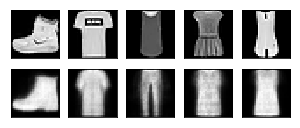

Epoch:  9 | train loss: 0.0247


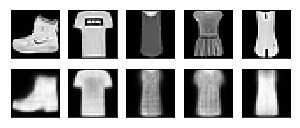

Epoch:  9 | train loss: 0.0229


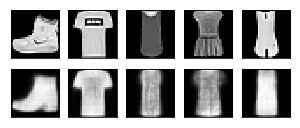

Done training in: 00:01:35 | Model saved as: IncrementalAutoEncoder.pt


In [9]:
# Train Incremental Autoencoder
train_model("IncrementalAutoEncoder", train_data, run_on=device, n_test_img=5)